<a href="https://colab.research.google.com/github/daggermaster3000/CZBIO-Interview/blob/main/run_Cellpose-SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Approach 3 Cellpose-SAM
This notebook is adapted from the notebook by
Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Cellpose-SAM and other libraries


In [2]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-s2_6dala
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-s2_6dala
  Resolved https://www.github.com/mouseland/cellpose.git to commit d95f58a6676362d4e625076e55cd73b47c3bae26
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 54.2 MB/s eta 0:00:00
  Created wheel for cellpose: filename=cellpose-4.0.7.dev14+gd95f58a66-py3-none-any.whl size=212496 sha256=336488b19845b558176064f43dcfd22b7354e093257ddeca03cdf7f9b1298a27
  Stored in directory: /tmp/pip-ephem-wheel-cache-8n59amgu/wheels/df/b6/31/a3013c44290eabb46f4c06d1efb19744124fcad2d59684ec5e
Successfully built cellpose


In [3]:
!pip install iohub tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.5/226.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 107.2 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5031 sha256=e6fab90e521a4bce8decf005374e93a43afeefc7204e05a6a2d07cb7fa3f5e9a
  Stored in directory: /root/.cache/pip/wheels/a5/d7/98/f56ae733748cd0fa577172bda0e73e0b1f1793c98e09b9e458
Successfully built asciitree
  Attempting uninstall: tifffile
    Found existing installation: tifffile 2025.8.28
    Uninstalling tifffile-2025.8.28:
      Successfully uninstalled tifffile-2025.8.28


In [28]:
!pip install pyclesperanto_prototype

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.0/624.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.7/732.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompat

Check GPU and instantiate model - will download weights.

In [1]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

2025-09-16 11:08:29,317 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-09-16 11:08:29,318 [INFO] 
cellpose version: 	4.0.7.dev14+gd95f58a66 
platform:       	linux 
python version: 	3.12.11 
torch version:  	2.8.0+cu126
2025-09-16 11:08:29,486 [INFO] ** TORCH CUDA version installed and working. **
2025-09-16 11:08:29,487 [INFO] ** TORCH CUDA version installed and working. **
2025-09-16 11:08:29,488 [INFO] >>>> using GPU (CUDA)
2025-09-16 11:08:32,013 [INFO] >>>> loading model /root/.cellpose/models/cpsam


## Parameters

Here are some of the parameters you can change:

* ***flow_threshold*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.
    *  **Increase** this threshold if cellpose is not returning as many masks as you’d expect (or turn off completely with 0.0)
    *   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

* ***cellprob_threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.
    *   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small
    *   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

* ***tile_norm_blocksize*** determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together.
  You may want to change this to 100-200 pixels if you have very inhomogeneous brightness across your image.



### Channel Selection:

- Use the dropdowns below to select the _zero-indexed_ channels of your image to segment. The order does not matter. Remember to rerun the cell after you edit the dropdowns.

- If you have a histological image taken in brightfield, you don't need to adjust the channels.

- If you have a fluroescent image with multiple stains, you should choose one channel with a cytoplasm/membrane stain, one channel with a nuclear stain, and set the third channel to `None`. Choosing multiple channels may produce segmentaiton of all the structures in the image. If you have retrained the model on your data with a thrid stain (described below), you can run segmentation with all channels.

In [ ]:
first_channel = 'None' # @param ['None', 0, 1, 2, 3, 4, 5]
second_channel = 'None' # @param ['None', 0, 1, 2, 3, 4, 5]
third_channel = 'None' # @param ['None', 0, 1, 2, 3, 4, 5]

# Process the whole zarr

2025-09-16 12:01:07,143 [INFO] ** TORCH CUDA version installed and working. **
GPU available: True
2025-09-16 12:01:07,145 [INFO] ** TORCH CUDA version installed and working. **
2025-09-16 12:01:07,145 [INFO] >>>> using GPU (CUDA)
2025-09-16 12:01:09,135 [INFO] >>>> loading model /root/.cellpose/models/cpsam
Input data shape (TCZYX): (10, 1, 78, 1500, 1600)


Segmenting timepoints:   0%|          | 0/10 [00:00<?, ?it/s]

2025-09-16 12:01:13,600 [INFO] running YX: 97 planes of size (659, 702)
2025-09-16 12:01:13,601 [INFO] 
2025-09-16 12:01:13,602 [INFO] 0%|          | 0/7 [00:00<?, ?it/s]
2025-09-16 12:01:13,602 [INFO] 
2025-09-16 12:01:35,456 [INFO] 100%|##########| 7/7 [00:21<00:00,  3.12s/it]
2025-09-16 12:01:36,447 [INFO] running ZY: 659 planes of size (97, 702)
2025-09-16 12:01:36,448 [INFO] 
2025-09-16 12:01:36,449 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:01:36,449 [INFO] 
2025-09-16 12:02:09,110 [INFO] 
2025-09-16 12:02:09,111 [INFO] 82%|########1 | 9/11 [00:32<00:07,  3.63s/it]
2025-09-16 12:02:09,112 [INFO] 
2025-09-16 12:02:13,804 [INFO] 100%|##########| 11/11 [00:37<00:00,  3.40s/it]
2025-09-16 12:02:14,195 [INFO] running ZX: 702 planes of size (97, 659)
2025-09-16 12:02:14,196 [INFO] 
2025-09-16 12:02:14,196 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:02:14,197 [INFO] 
2025-09-16 12:02:47,742 [INFO] 
2025-09-16 12:02:47,743 [INFO] 82%|########1 | 9/11 [00:33<0

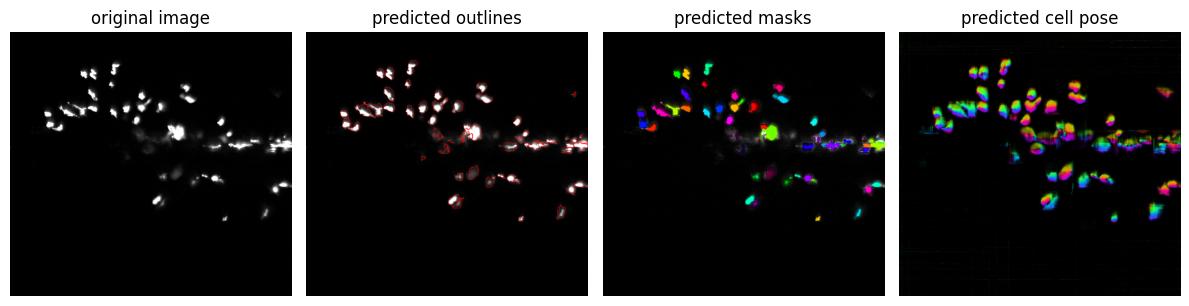

Segmenting timepoints:  10%|█         | 1/10 [01:52<16:49, 112.14s/it]

2025-09-16 12:03:05,724 [INFO] running YX: 97 planes of size (659, 702)
2025-09-16 12:03:05,725 [INFO] 
2025-09-16 12:03:05,726 [INFO] 0%|          | 0/7 [00:00<?, ?it/s]
2025-09-16 12:03:05,727 [INFO] 
2025-09-16 12:03:27,862 [INFO] 100%|##########| 7/7 [00:22<00:00,  3.16s/it]
2025-09-16 12:03:28,869 [INFO] running ZY: 659 planes of size (97, 702)
2025-09-16 12:03:28,870 [INFO] 
2025-09-16 12:03:28,870 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:03:28,871 [INFO] 
2025-09-16 12:04:01,884 [INFO] 
2025-09-16 12:04:01,885 [INFO] 82%|########1 | 9/11 [00:33<00:07,  3.67s/it]
2025-09-16 12:04:01,886 [INFO] 
2025-09-16 12:04:06,645 [INFO] 100%|##########| 11/11 [00:37<00:00,  3.43s/it]
2025-09-16 12:04:07,040 [INFO] running ZX: 702 planes of size (97, 659)
2025-09-16 12:04:07,041 [INFO] 
2025-09-16 12:04:07,041 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:04:07,042 [INFO] 
2025-09-16 12:04:37,155 [INFO] 
2025-09-16 12:04:37,156 [INFO] 73%|#######2  | 8/11 [00:30<0

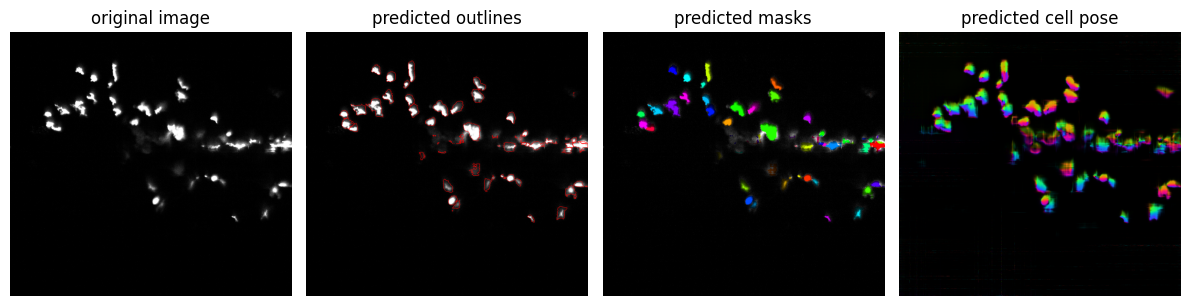

Segmenting timepoints:  20%|██        | 2/10 [03:45<15:03, 112.89s/it]

2025-09-16 12:04:59,095 [INFO] running YX: 97 planes of size (659, 702)
2025-09-16 12:04:59,096 [INFO] 
2025-09-16 12:04:59,096 [INFO] 0%|          | 0/7 [00:00<?, ?it/s]
2025-09-16 12:04:59,097 [INFO] 
2025-09-16 12:05:20,949 [INFO] 100%|##########| 7/7 [00:21<00:00,  3.12s/it]
2025-09-16 12:05:21,946 [INFO] running ZY: 659 planes of size (97, 702)
2025-09-16 12:05:21,947 [INFO] 
2025-09-16 12:05:21,948 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:05:21,949 [INFO] 
2025-09-16 12:05:54,541 [INFO] 
2025-09-16 12:05:54,542 [INFO] 82%|########1 | 9/11 [00:32<00:07,  3.62s/it]
2025-09-16 12:05:54,543 [INFO] 
2025-09-16 12:05:59,204 [INFO] 100%|##########| 11/11 [00:37<00:00,  3.39s/it]
2025-09-16 12:05:59,602 [INFO] running ZX: 702 planes of size (97, 659)
2025-09-16 12:05:59,603 [INFO] 
2025-09-16 12:05:59,604 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:05:59,605 [INFO] 
2025-09-16 12:06:33,012 [INFO] 
2025-09-16 12:06:33,013 [INFO] 82%|########1 | 9/11 [00:33<0

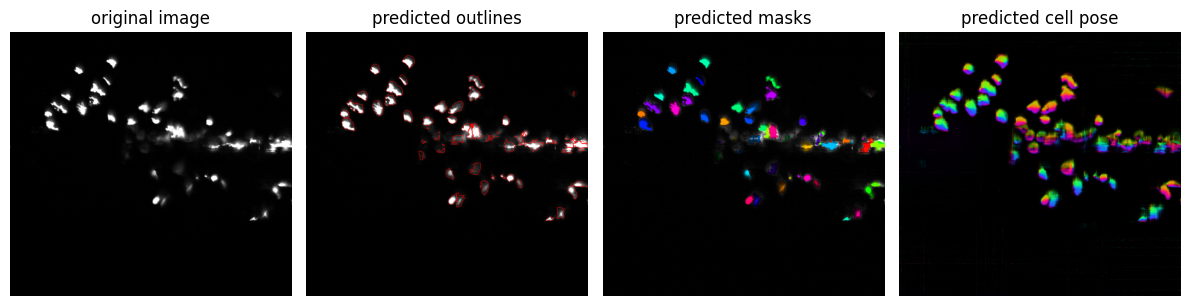

Segmenting timepoints:  30%|███       | 3/10 [05:37<13:06, 112.33s/it]

2025-09-16 12:06:50,792 [INFO] running YX: 97 planes of size (659, 702)
2025-09-16 12:06:50,793 [INFO] 
2025-09-16 12:06:50,794 [INFO] 0%|          | 0/7 [00:00<?, ?it/s]
2025-09-16 12:06:50,795 [INFO] 
2025-09-16 12:07:13,015 [INFO] 100%|##########| 7/7 [00:22<00:00,  3.17s/it]
2025-09-16 12:07:14,016 [INFO] running ZY: 659 planes of size (97, 702)
2025-09-16 12:07:14,017 [INFO] 
2025-09-16 12:07:14,018 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:07:14,019 [INFO] 
2025-09-16 12:07:47,094 [INFO] 
2025-09-16 12:07:47,095 [INFO] 82%|########1 | 9/11 [00:33<00:07,  3.67s/it]
2025-09-16 12:07:47,095 [INFO] 
2025-09-16 12:07:51,875 [INFO] 100%|##########| 11/11 [00:37<00:00,  3.44s/it]
2025-09-16 12:07:52,264 [INFO] running ZX: 702 planes of size (97, 659)
2025-09-16 12:07:52,265 [INFO] 
2025-09-16 12:07:52,265 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:07:52,266 [INFO] 
2025-09-16 12:08:22,473 [INFO] 
2025-09-16 12:08:22,473 [INFO] 73%|#######2  | 8/11 [00:30<0

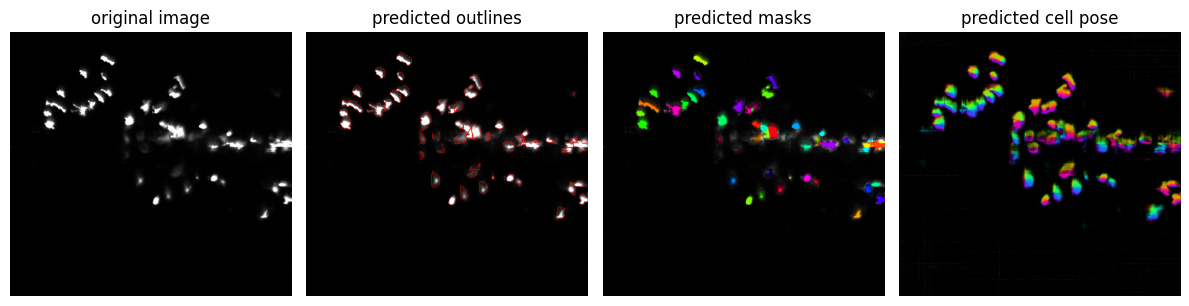

Segmenting timepoints:  40%|████      | 4/10 [07:30<11:16, 112.83s/it]

2025-09-16 12:08:44,380 [INFO] running YX: 97 planes of size (659, 702)
2025-09-16 12:08:44,381 [INFO] 
2025-09-16 12:08:44,382 [INFO] 0%|          | 0/7 [00:00<?, ?it/s]
2025-09-16 12:08:44,382 [INFO] 
2025-09-16 12:09:06,324 [INFO] 100%|##########| 7/7 [00:21<00:00,  3.13s/it]
2025-09-16 12:09:07,328 [INFO] running ZY: 659 planes of size (97, 702)
2025-09-16 12:09:07,329 [INFO] 
2025-09-16 12:09:07,330 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:09:07,331 [INFO] 
2025-09-16 12:09:40,024 [INFO] 
2025-09-16 12:09:40,025 [INFO] 82%|########1 | 9/11 [00:32<00:07,  3.63s/it]
2025-09-16 12:09:40,026 [INFO] 
2025-09-16 12:09:44,718 [INFO] 100%|##########| 11/11 [00:37<00:00,  3.40s/it]
2025-09-16 12:09:45,108 [INFO] running ZX: 702 planes of size (97, 659)
2025-09-16 12:09:45,109 [INFO] 
2025-09-16 12:09:45,109 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:09:45,110 [INFO] 
2025-09-16 12:10:18,684 [INFO] 
2025-09-16 12:10:18,685 [INFO] 82%|########1 | 9/11 [00:33<0

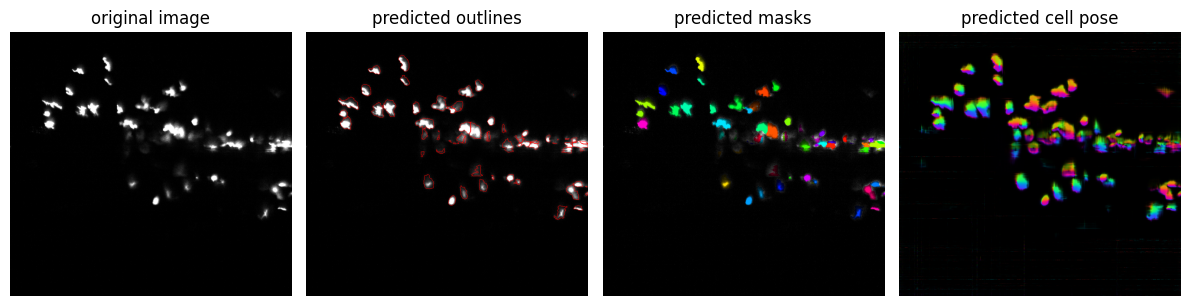

Segmenting timepoints:  50%|█████     | 5/10 [09:23<09:23, 112.61s/it]

2025-09-16 12:10:36,598 [INFO] running YX: 97 planes of size (659, 702)
2025-09-16 12:10:36,599 [INFO] 
2025-09-16 12:10:36,600 [INFO] 0%|          | 0/7 [00:00<?, ?it/s]
2025-09-16 12:10:36,600 [INFO] 
2025-09-16 12:10:58,714 [INFO] 100%|##########| 7/7 [00:22<00:00,  3.16s/it]
2025-09-16 12:10:59,716 [INFO] running ZY: 659 planes of size (97, 702)
2025-09-16 12:10:59,716 [INFO] 
2025-09-16 12:10:59,717 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:10:59,718 [INFO] 
2025-09-16 12:11:32,704 [INFO] 
2025-09-16 12:11:32,705 [INFO] 82%|########1 | 9/11 [00:32<00:07,  3.67s/it]
2025-09-16 12:11:32,705 [INFO] 
2025-09-16 12:11:37,469 [INFO] 100%|##########| 11/11 [00:37<00:00,  3.43s/it]
2025-09-16 12:11:37,861 [INFO] running ZX: 702 planes of size (97, 659)
2025-09-16 12:11:37,862 [INFO] 
2025-09-16 12:11:37,863 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:11:37,864 [INFO] 
2025-09-16 12:12:08,001 [INFO] 
2025-09-16 12:12:08,002 [INFO] 73%|#######2  | 8/11 [00:30<0

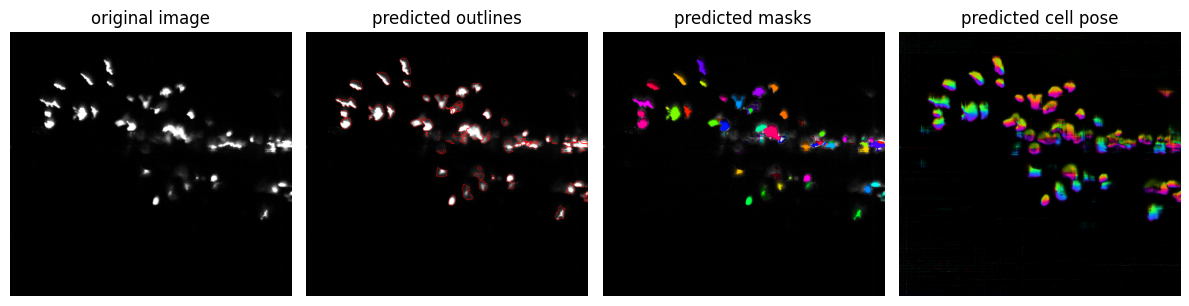

Segmenting timepoints:  60%|██████    | 6/10 [11:16<07:31, 112.83s/it]

2025-09-16 12:12:29,854 [INFO] running YX: 97 planes of size (659, 702)
2025-09-16 12:12:29,855 [INFO] 
2025-09-16 12:12:29,856 [INFO] 0%|          | 0/7 [00:00<?, ?it/s]
2025-09-16 12:12:29,856 [INFO] 
2025-09-16 12:12:51,710 [INFO] 100%|##########| 7/7 [00:21<00:00,  3.12s/it]
2025-09-16 12:12:52,721 [INFO] running ZY: 659 planes of size (97, 702)
2025-09-16 12:12:52,722 [INFO] 
2025-09-16 12:12:52,723 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:12:52,723 [INFO] 
2025-09-16 12:13:25,324 [INFO] 
2025-09-16 12:13:25,324 [INFO] 82%|########1 | 9/11 [00:32<00:07,  3.62s/it]
2025-09-16 12:13:25,325 [INFO] 
2025-09-16 12:13:30,079 [INFO] 100%|##########| 11/11 [00:37<00:00,  3.40s/it]
2025-09-16 12:13:30,476 [INFO] running ZX: 702 planes of size (97, 659)
2025-09-16 12:13:30,477 [INFO] 
2025-09-16 12:13:30,478 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:13:30,479 [INFO] 
2025-09-16 12:14:03,904 [INFO] 
2025-09-16 12:14:03,905 [INFO] 82%|########1 | 9/11 [00:33<0

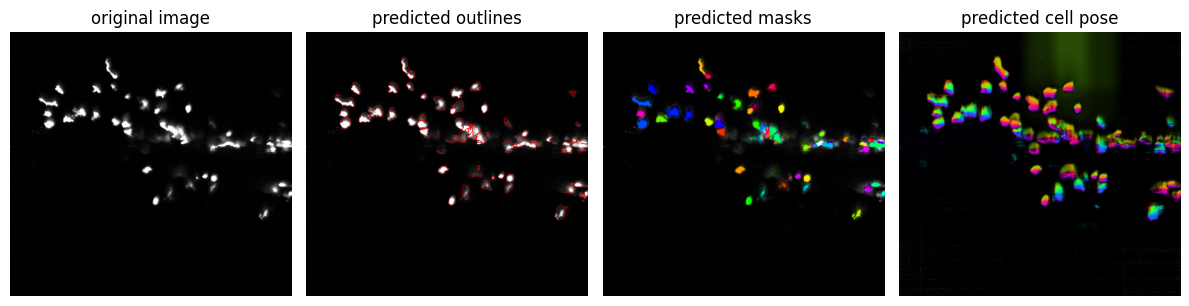

Segmenting timepoints:  70%|███████   | 7/10 [13:08<05:37, 112.62s/it]

2025-09-16 12:14:22,040 [INFO] running YX: 97 planes of size (659, 702)
2025-09-16 12:14:22,041 [INFO] 
2025-09-16 12:14:22,041 [INFO] 0%|          | 0/7 [00:00<?, ?it/s]
2025-09-16 12:14:22,042 [INFO] 
2025-09-16 12:14:44,192 [INFO] 100%|##########| 7/7 [00:22<00:00,  3.16s/it]
2025-09-16 12:14:45,178 [INFO] running ZY: 659 planes of size (97, 702)
2025-09-16 12:14:45,179 [INFO] 
2025-09-16 12:14:45,179 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:14:45,180 [INFO] 
2025-09-16 12:15:18,097 [INFO] 
2025-09-16 12:15:18,098 [INFO] 82%|########1 | 9/11 [00:32<00:07,  3.66s/it]
2025-09-16 12:15:18,099 [INFO] 
2025-09-16 12:15:22,854 [INFO] 100%|##########| 11/11 [00:37<00:00,  3.42s/it]
2025-09-16 12:15:23,250 [INFO] running ZX: 702 planes of size (97, 659)
2025-09-16 12:15:23,251 [INFO] 
2025-09-16 12:15:23,252 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:15:23,253 [INFO] 
2025-09-16 12:15:53,307 [INFO] 
2025-09-16 12:15:53,308 [INFO] 73%|#######2  | 8/11 [00:30<0

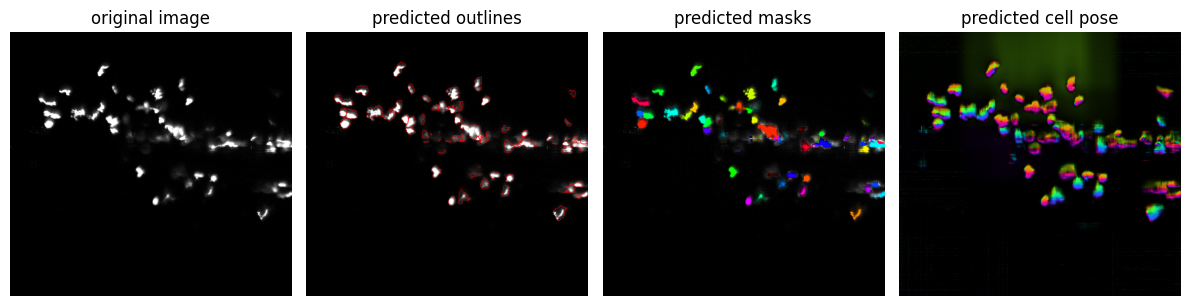

Segmenting timepoints:  80%|████████  | 8/10 [15:01<03:45, 112.78s/it]

2025-09-16 12:16:15,152 [INFO] running YX: 97 planes of size (659, 702)
2025-09-16 12:16:15,153 [INFO] 
2025-09-16 12:16:15,153 [INFO] 0%|          | 0/7 [00:00<?, ?it/s]
2025-09-16 12:16:15,154 [INFO] 
2025-09-16 12:16:36,992 [INFO] 100%|##########| 7/7 [00:21<00:00,  3.12s/it]
2025-09-16 12:16:37,993 [INFO] running ZY: 659 planes of size (97, 702)
2025-09-16 12:16:37,993 [INFO] 
2025-09-16 12:16:37,994 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:16:37,994 [INFO] 
2025-09-16 12:17:10,616 [INFO] 
2025-09-16 12:17:10,617 [INFO] 82%|########1 | 9/11 [00:32<00:07,  3.62s/it]
2025-09-16 12:17:10,617 [INFO] 
2025-09-16 12:17:15,287 [INFO] 100%|##########| 11/11 [00:37<00:00,  3.39s/it]
2025-09-16 12:17:15,687 [INFO] running ZX: 702 planes of size (97, 659)
2025-09-16 12:17:15,688 [INFO] 
2025-09-16 12:17:15,688 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:17:15,689 [INFO] 
2025-09-16 12:17:49,169 [INFO] 
2025-09-16 12:17:49,169 [INFO] 82%|########1 | 9/11 [00:33<0

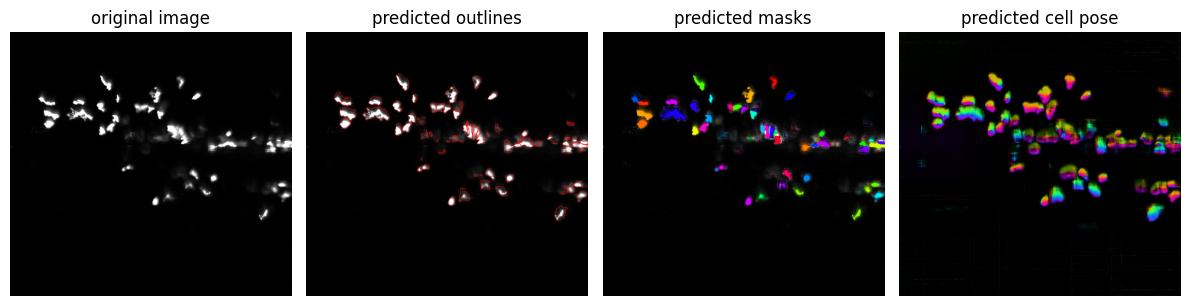

Segmenting timepoints:  90%|█████████ | 9/10 [16:53<01:52, 112.56s/it]

2025-09-16 12:18:07,224 [INFO] running YX: 97 planes of size (659, 702)
2025-09-16 12:18:07,225 [INFO] 
2025-09-16 12:18:07,226 [INFO] 0%|          | 0/7 [00:00<?, ?it/s]
2025-09-16 12:18:07,226 [INFO] 
2025-09-16 12:18:29,325 [INFO] 100%|##########| 7/7 [00:22<00:00,  3.16s/it]
2025-09-16 12:18:30,319 [INFO] running ZY: 659 planes of size (97, 702)
2025-09-16 12:18:30,320 [INFO] 
2025-09-16 12:18:30,321 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:18:30,322 [INFO] 
2025-09-16 12:19:03,293 [INFO] 
2025-09-16 12:19:03,293 [INFO] 82%|########1 | 9/11 [00:32<00:07,  3.66s/it]
2025-09-16 12:19:03,294 [INFO] 
2025-09-16 12:19:08,060 [INFO] 100%|##########| 11/11 [00:37<00:00,  3.43s/it]
2025-09-16 12:19:08,454 [INFO] running ZX: 702 planes of size (97, 659)
2025-09-16 12:19:08,455 [INFO] 
2025-09-16 12:19:08,455 [INFO] 0%|          | 0/11 [00:00<?, ?it/s]
2025-09-16 12:19:08,456 [INFO] 
2025-09-16 12:19:38,557 [INFO] 
2025-09-16 12:19:38,558 [INFO] 73%|#######2  | 8/11 [00:30<0

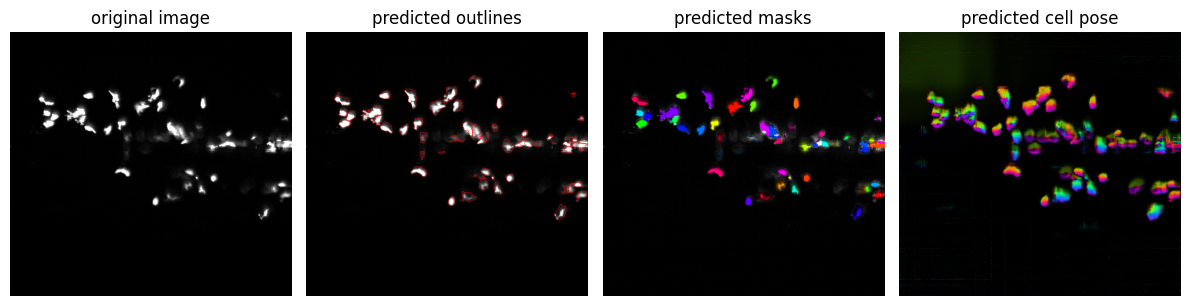

Segmenting timepoints: 100%|██████████| 10/10 [18:46<00:00, 112.68s/it]

/
 └── 0 (10, 1, 97, 659, 702) uint16
Segmentation complete. Masks saved at /content/drive/MyDrive/segmented_masks.zarr


In [11]:
import numpy as np
from iohub.ngff import open_ome_zarr
from pathlib import Path
from tqdm import tqdm
import shutil
from cellpose import models, plot, core
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle
import numpy as np
from iohub import open_ome_zarr
import pyclesperanto_prototype as cle


# --------------------------------------------
# Paths
# --------------------------------------------
input_path = Path("/content/drive/MyDrive/take_home_dataset_1.zarr")
output_path = Path("/content/drive/MyDrive/segmented_masks.zarr")
shutil.rmtree(output_path, ignore_errors=True)  # delete if exists

# --------------------------------------------
# Check GPU availability
# --------------------------------------------
use_gpu = core.use_gpu()
print("GPU available:", use_gpu)

# --------------------------------------------
# Cellpose model
# --------------------------------------------
model = models.CellposeModel(gpu=True)

# --------------------------------------------
# Open OME-Zarr dataset
# --------------------------------------------
with open_ome_zarr(input_path, mode="r", layout="auto") as dataset:

    img_array = dataset["0"]  # first position
    raw_data = img_array.numpy()  # TCZYX

    n_timepoints, n_channels = raw_data.shape[0], raw_data.shape[1]
    print("Input data shape (TCZYX):", raw_data.shape)

    # Assume single channel segmentation
    channel = 0

    # Create output Zarr for masks
    Z, Y, X = (97, 659, 702)  # if I have time I will not hardcode this
    with open_ome_zarr(output_path, layout="fov", mode="w-", channel_names=["Masks"]) as out_ds:
        masks_img = out_ds.create_zeros(
            name="0",
            shape=(n_timepoints, 1, Z, Y, X),
            dtype=np.uint16
        )

        # --------------------------------------------
        # Loop through timepoints
        # --------------------------------------------
        for t in tqdm(range(n_timepoints), desc="Segmenting timepoints"):
            vol = raw_data[t, channel]  # ZYX
            vol = np.array(vol, dtype=np.float32)
            # rescale for isotropic and compariuson with the other segmentation methods
            voxel_size_z, voxel_size_y, voxel_size_x = [1.24, 0.439, 0.439] # if I have time I will not hardcode this
            iso_data = cle.scale(vol, factor_x=voxel_size_x, factor_y=voxel_size_y, factor_z=voxel_size_z, auto_size=True)
            iso_data_np = cle.pull(iso_data)  # get NumPy array from GPU
            iso_data_np = iso_data_np[..., None]  # add channel axis → shape: Z,Y,X,1
            # Run 3D Cellpose segmentation
            masks, flows, styles = model.eval(
                iso_data_np,
                batch_size=256,
                flow_threshold=0.4,
                cellprob_threshold=0.0,
                z_axis=0,
                channel_axis=3,
                do_3D=True,
                normalize={"tile_norm_blocksize": 0},
            )

            # Save masks into output Zarr
            masks_img[t, 0, :, :, :] = masks.astype(np.uint16)

            # Optional: visualize middle slice
            z_mid = masks.shape[0] // 2
            fig = plt.figure(figsize=(12,5))
            plot.show_segmentation(fig, iso_data_np[z_mid], masks[z_mid], flows[0][z_mid])
            plt.tight_layout()
            plt.show()

        out_ds.print_tree()

print(f"Segmentation complete. Masks saved at {output_path}")
